In [1]:
import pandas as pd

import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [102]:
# Global Variables
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE
WINDOW_SIZE = 10
#MAX_SEQ_LENGTH = 11
NUM_NS = 3

## Data Collection and Indexing

We're going to use tensorflow's build in TextVectorization layer to convert a corpus of lists of genres into indexes.

First we're importing a dataframe in using pandas (I think I can remove this step and do this with TF later #TODO)

In [103]:
data = pd.read_csv('data/data_w_genres.csv')
corpus = data['genres']
corpus = corpus[corpus != '[]']
corpus = corpus.str.lstrip('[')
corpus = corpus.str.rstrip(']')
corpus = corpus.str.replace("'", '')
corpus = corpus.str.split(', ')
corpus.head()

0                                          [show tunes]
8                          [comedy rock, comic, parody]
9     [emo rap, florida rap, sad rap, underground hi...
10                                [dark trap, meme rap]
12    [asian american hip hop, cali rap, west coast ...
Name: genres, dtype: object

In [4]:
# # this may appear redundant with the vectorize layer but I need to get the 
# # total number of genres present to estable a max "vocab" size

# genre_seq = []
# for values in corpus:
#     for genre in values.split(', '):
#         genre_seq.append(genre)
# genres = set(genre_seq)

# vocab_size = len(genres)

# print(FindMaxLength(genre_seq))

In [104]:
genre_sequences = list(corpus)
flat_corpus = [item for sublist in genre_sequences for item in sublist]
genres = set(flat_corpus)

# vocab_size = len(genres)

In [44]:
genre_sequences[:5]

[['show tunes'],
 ['comedy rock', 'comic', 'parody'],
 ['emo rap', 'florida rap', 'sad rap', 'underground hip hop', 'vapor trap'],
 ['dark trap', 'meme rap'],
 ['asian american hip hop', 'cali rap', 'west coast trap']]

I realized after running through this process once, that there are genres clustered together that don't appear related. I wonder if this is due to some genres having lower frequencies than others. I'm going to do a quick frequency EDA on the occurances of genres in the original corpus.

In [107]:
df = pd.DataFrame(flat_corpus)

In [108]:
frequency = pd.DataFrame(df.value_counts())
frequency.head()

,0
0,
rock,611
pop,593
dance pop,572
rap,516
hip hop,507


In [109]:
frequency.columns = ['occurances']

In [110]:
frequency.index.rename('genre', inplace = True)

In [111]:
frequency.reset_index(inplace = True)

In [112]:
frequency.head()

,genre,occurances
0,rock,611
1,pop,593
2,dance pop,572
3,rap,516
4,hip hop,507


<AxesSubplot:ylabel='Frequency'>

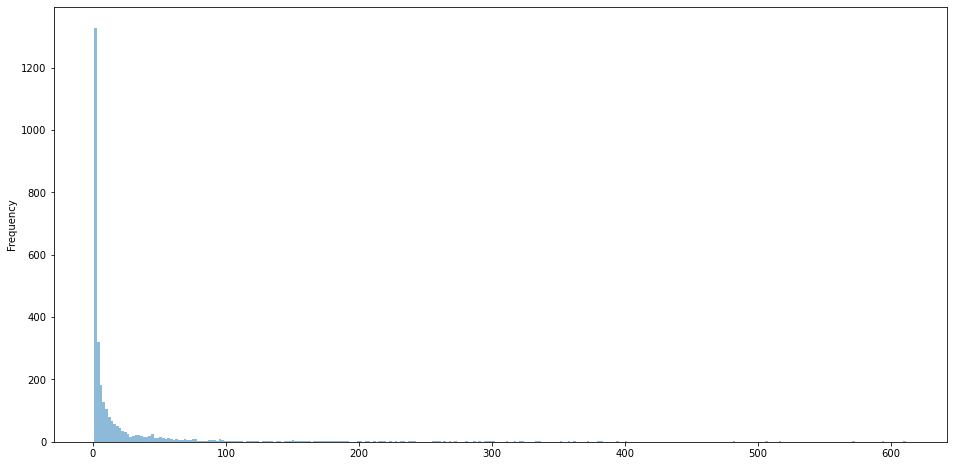

In [113]:
frequency['occurances'].plot.hist(bins=300, alpha=0.5, figsize=(16,8))

In [114]:
mask = frequency['occurances'] > 25
trim_freq = frequency[mask]
print("percent remaining: " + str(100*len(trim_freq)/len(frequency)))
print("length of dataset: "+ str(len(trim_freq)))

percent remaining: 18.23687752355316
length of dataset: 542


In [160]:
# genre2int = {}

# for i,genre in enumerate(genres):
#     genre2int[genre] = i


# i+1 is required because the value `0` will be used for padding
genre2int = {}

genre2int[''] = 0 # manually adding padding token
for i,genre in enumerate(trim_freq['genre']):
    genre2int[genre] = i+1

In [161]:
genre2int

{'': 0,
 'rock': 1,
 'pop': 2,
 'dance pop': 3,
 'rap': 4,
 'hip hop': 5,
 'pop rap': 6,
 'pop rock': 7,
 'modern rock': 8,
 'country rock': 9,
 'urban contemporary': 10,
 'folk rock': 11,
 'latin': 12,
 'soft rock': 13,
 'trap': 14,
 'mellow gold': 15,
 'funk': 16,
 'classic rock': 17,
 'adult standards': 18,
 'pop dance': 19,
 'indie pop': 20,
 'southern hip hop': 21,
 'alternative rock': 22,
 'album rock': 23,
 'indie rock': 24,
 'gangster rap': 25,
 'alternative metal': 26,
 'country': 27,
 'regional mexican': 28,
 'new wave pop': 29,
 'soul': 30,
 'r&b': 31,
 'post-teen pop': 32,
 'tropical': 33,
 'quiet storm': 34,
 'folk': 35,
 'art rock': 36,
 'hard rock': 37,
 'dance rock': 38,
 'classical performance': 39,
 'roots rock': 40,
 'edm': 41,
 'brill building pop': 42,
 'indie folk': 43,
 'electropop': 44,
 'contemporary country': 45,
 'hip pop': 46,
 'blues rock': 47,
 'underground hip hop': 48,
 'corrido': 49,
 'stomp and holler': 50,
 'motown': 51,
 'classic soul': 52,
 'punk': 

In [168]:
int2genre = {index: genre for genre, index in genre2int.items()}
int2genre

{0: '',
 1: 'rock',
 2: 'pop',
 3: 'dance pop',
 4: 'rap',
 5: 'hip hop',
 6: 'pop rap',
 7: 'pop rock',
 8: 'modern rock',
 9: 'country rock',
 10: 'urban contemporary',
 11: 'folk rock',
 12: 'latin',
 13: 'soft rock',
 14: 'trap',
 15: 'mellow gold',
 16: 'funk',
 17: 'classic rock',
 18: 'adult standards',
 19: 'pop dance',
 20: 'indie pop',
 21: 'southern hip hop',
 22: 'alternative rock',
 23: 'album rock',
 24: 'indie rock',
 25: 'gangster rap',
 26: 'alternative metal',
 27: 'country',
 28: 'regional mexican',
 29: 'new wave pop',
 30: 'soul',
 31: 'r&b',
 32: 'post-teen pop',
 33: 'tropical',
 34: 'quiet storm',
 35: 'folk',
 36: 'art rock',
 37: 'hard rock',
 38: 'dance rock',
 39: 'classical performance',
 40: 'roots rock',
 41: 'edm',
 42: 'brill building pop',
 43: 'indie folk',
 44: 'electropop',
 45: 'contemporary country',
 46: 'hip pop',
 47: 'blues rock',
 48: 'underground hip hop',
 49: 'corrido',
 50: 'stomp and holler',
 51: 'motown',
 52: 'classic soul',
 53: 'pun

In [164]:
vocab_size = len(genre2int)
vocab_size

543

In [165]:
genre_int_sequences = []
for sequence in genre_sequences:
    genre_int_sequences.append([genre2int[genre] for genre in sequence if genre in list(trim_freq['genre'])])
    
# genre_int_sequences = genre_int_sequences[genre_int_sequences != '[]']
genre_int_sequences = [sequence for sequence in genre_int_sequences if sequence != []]
genre_int_sequences[:5]

[[55], [144], [142, 200, 48, 138], [241, 313], [198, 250]]

In [166]:
print(f"Data set size is now {len(genre_int_sequences)} instead of original size of {len(corpus)}. This is {100*len(genre_int_sequences)/len(corpus)}% of the original data")

Data set size is now 16029 instead of original size of 18823. This is 85.1564575253679% of the original data


Although over 80% of the genres were removed, 85% of the sequences still remain. For completeness, I'm going to update the vocabulary size.

Ultimately, we want a list of lists where the sublists represent a sequence of genres in index form. However, for the word2vec model, we need padded lists. Normally this is handled in the TextVectorization class, however, because I am using genres (which are sometimes comprised of multiple words) instead of a strict one-word vocabulary, I am going to manually create the require numpy array of genre indexs and pad these lists using the `pad_sequences` method in the [preprocessing library](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences#used-in-the-notebooks).

In [167]:
padded_int_sequences = pad_sequences(
    genre_int_sequences, 
    padding="post",
    value=0)

In [169]:
for seq in padded_int_sequences[:3]:
    print(f"{seq} => {[int2genre[i] for i in seq]}")

[55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] => ['show tunes', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] => ['comic', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[142 200  48 138   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] => ['emo rap', 'sad rap', 'underground hip hop', 'vapor trap', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [127]:
type(padded_int_sequences)

numpy.ndarray

## Generating skip-grams

## Scaling Up: Generating Full Train Data

Now we'll take all steps above and write a function to handle a list of vectorized "sentences" (or vectorize genre list in this case). A *sampling table* is built first and the tuples of target, context and labels are generated.

In [209]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and genre-options size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=SEED, 
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

Now I should be able to use this function to construct a list of targets, contexts, and labels.

In [210]:
targets, contexts, labels = generate_training_data(
    sequences=padded_int_sequences, 
    window_size=WINDOW_SIZE, 
    num_ns=NUM_NS, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 16029/16029 [00:01<00:00, 14353.50it/s]


14913 14913 14913


In [211]:
print(f"target  :", targets[0])
print(f"context :", contexts[0] )
print(f"label   :", labels[0] )

target  : 241
context : tf.Tensor(
[[313]
 [  0]
 [  7]
 [  3]], shape=(4, 1), dtype=int64)
label   : tf.Tensor([1 0 0 0], shape=(4,), dtype=int64)


## Configure the Dataset for Performance

We can put the lists of targets, contexts, and labels together in a formal TF dataset structure using `tf.data.Dataset` which is an object of `(target_word, context_word), (label)`.

[Batching](https://stackoverflow.com/questions/41175401/what-is-a-batch-in-tensorflow), in short, is a method of training on your data faster. `batch_size` is a hyperparameter and there is no "right" answer of what to use. Though, larger batch sizes may lead to overfitting. 

[Shuffling](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) a dataset allows for better randomization within batches, The dataset is filled into a buffer of size `Buffer_size` and replaces selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required. So in this case, I think the dataset size is 15043 elements.

BatchDataset shapes look correct per the example, even without squeezing. Although, I did tweak my code by setting `drop_remainder` to False.

[Caching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) simply caches the elements of the dataset into memory. cached data persists across runs.

[Prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) allows for faster processing as later elements are prepared while current elements are being processed. Autotuning can be used to select the maximum number of elements that will be buffered when prefetching.

In [217]:
BATCH_SIZE = 512
BUFFER_SIZE = 15045
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=False)
print(dataset)

<BatchDataset shapes: (((None,), (None, 4, 1)), (None, 4)), types: ((tf.int32, tf.int64), tf.int64)>


In [218]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((None,), (None, 4, 1)), (None, 4)), types: ((tf.int32, tf.int64), tf.int64)>


## Model and Training

The Word2Vec model can be implemented as a classifier to distinguish between true context words from skip-grams and false context words obtained through negative sampling. You can perform a dot product between the *embeddings*, or the vectorized value, of target and context words to obtain predictions for labels and compute loss against true labels in the dataset.

This Word2Vec model class is comprised of:
* a `target_embedding` layer which looks up the embedding of the word as it appears as a target word.
* a `context_embedding` layer which looks up the embedding of the word as it appears as a context word.
* a `dots` layer which computes to dot product of the target and context embedding from a training pair
* a `flatten` layer

In [219]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=NUM_NS+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

In [220]:
embedding_dim = 64 # specifies how many dimensions will be present in the vector
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [195]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [221]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Train for 30 steps
Epoch 1/20
30/30 [==============================] - 1s 22ms/step - loss: 1.3837 - accuracy: 0.3817
Epoch 2/20
30/30 [==============================] - 0s 3ms/step - loss: 1.3701 - accuracy: 0.7424
Epoch 3/20
30/30 [==============================] - 0s 3ms/step - loss: 1.3393 - accuracy: 0.8536
Epoch 4/20
30/30 [==============================] - 0s 3ms/step - loss: 1.2740 - accuracy: 0.8720
Epoch 5/20
30/30 [==============================] - 0s 3ms/step - loss: 1.1679 - accuracy: 0.8692
Epoch 6/20
30/30 [==============================] - 0s 3ms/step - loss: 1.0343 - accuracy: 0.8674
Epoch 7/20
30/30 [==============================] - 0s 3ms/step - loss: 0.8964 - accuracy: 0.8698
Epoch 8/20
30/30 [==============================] - 0s 3ms/step - loss: 0.7710 - accuracy: 0.8764
Epoch 9/20
30/30 [==============================] - 0s 3ms/step - loss: 0.6648 - accuracy: 0.8843
Epoch 10/20
30/30 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.8928

Finally, I need to extract the weights calculated in the Word2Vec model. I'll map these weights to genres analyzed, as the represent the vectorized values of each genre.

In [222]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = list(genre2int.keys())

In [223]:
weights.shape

(543, 64)

In [224]:
len(vocab)

543

In [184]:
weights[542]

array([-0.02566251, -0.03684659,  0.04696095,  0.04092639,  0.19558457,
        0.07151715,  0.12419757,  0.02087529,  0.13443367, -0.00704023,
       -0.16546522,  0.22677399, -0.16449337,  0.04463615,  0.08320755,
       -0.24131048,  0.12563606,  0.02252813, -0.08539491,  0.05969479,
       -0.15315773,  0.15332742,  0.27032346,  0.08926421,  0.1320093 ,
       -0.03658031, -0.12291213,  0.04894289, -0.18900444,  0.05244822,
       -0.15625568, -0.15909971,  0.190758  , -0.1832533 ,  0.09840135,
       -0.21651968,  0.09415363, -0.16824836,  0.22488105,  0.13072215,
       -0.17244014, -0.12023723, -0.00152426,  0.23992723, -0.03994943,
        0.17446434,  0.1158358 , -0.16411959, -0.00536193,  0.08898483,
       -0.08505112,  0.26303005,  0.16270216, -0.16593   ,  0.17635787,
        0.22810085,  0.04714986, -0.11846168,  0.2003727 , -0.14836074,
        0.20407706,  0.01557999,  0.03144483, -0.07595079, -0.06099206,
        0.20128731, -0.19433336,  0.02961831,  0.09441913,  0.13

In [190]:
vocab[0]

''

In [226]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

### File descriptions:

`01` -- no trimmed genres

`02` -- trimmed genres and batch `drop_remainder` set to `False`

`03` -- changing embedded dimensions to 64? tried 16 and 24 but the accuracies fell below 90%.

`04` -- changed the batch size and buffer size. 

## Resources

* [Word2Vec Documentation](https://www.tensorflow.org/tutorials/text/word2vec)
* [Visualizer](https://projector.tensorflow.org/)